In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
# produce V1_allpos, V1_feature, V1_RF

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from patch_square import *

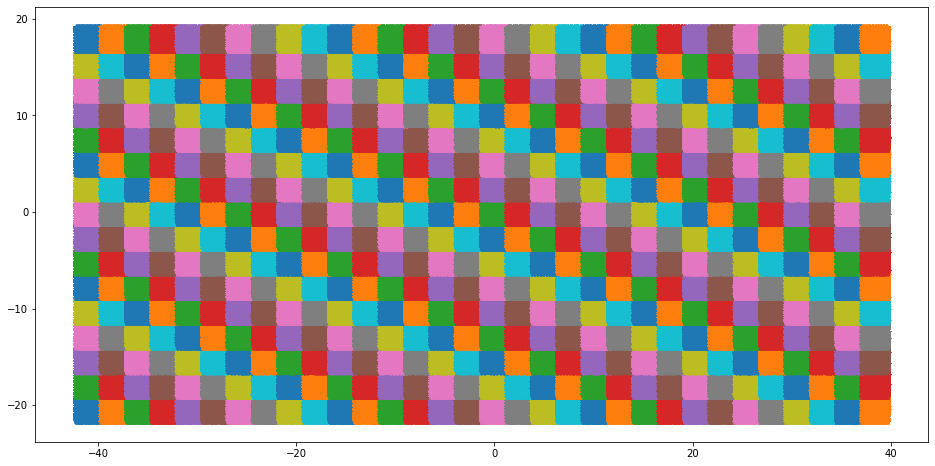

In [12]:
# area per block (1024 neurons) ~ 0.069  𝑚𝑚2 
# model density ~ 14766.156 per  𝑚𝑚2
fp = 'f4'
per_dis = 0.08 #mm
grid_h, grid_w = 16, 32
block_h, block_w = 32, 32
dim = 2
nblock = grid_h*grid_w
blockSize = block_w*block_h
nV1 = nblock*blockSize
pos = np.zeros((nblock, 2, blockSize), dtype = fp)

block_center = np.zeros((nblock,2))
block_center[:,0] = np.tile((np.arange(grid_w)-grid_w/2)*block_w*per_dis, grid_h)
block_center[:,1] = np.repeat((np.arange(grid_h)-grid_h/2)*block_h*per_dis, grid_w)

fig = plt.figure(figsize = [16, 8])
ax = fig.add_subplot(111)
ax.plot(block_center[:,0], block_center[:,1], '*k')

for i in range(nblock):
    pos[i,:,:] = square_pos(np.array([per_dis, per_dis]), block_w, block_h, block_center[i,:])
    ax.plot(pos[i,0,:], pos[i,1,:], '*')

#for i in range(nblock):
#    get_block_pos

In [14]:
# features

NameError: name 'square_pos' is not defined

In [9]:
pos_filename = 'V1_pos_square_layout_2D.bin'
with open(pos_filename, 'wb') as f:
    np.array([nblock, blockSize, dim]).astype('u4').tofile(f)
    pos.tofile(f)

NameError: name 'square_pos' is not defined

In [8]:
np.repeat(np.arange(5),2)
np.tile(np.arange(5),2)

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])